In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd

import matplotlib.pyplot as plt
from copy import copy

In [3]:
def read_json(file: str) -> dict:
    with open(file, 'r') as f:
        dict_ = json.load(f)
    return dict_


In [4]:
infra = read_json('infra1.json')

In [5]:
routes = [route['id'] for route in infra['routes']]
routes

['rt.DA1->DA_out',
 'rt.buffer_stop.0->DA1',
 'rt.DA2->DA_out',
 'rt.buffer_stop.1->DA2',
 'rt.DA_out->DB_in',
 'rt.DB_in->DB2',
 'rt.DB_in->DB1',
 'rt.DB1->buffer_stop.2',
 'rt.DB2->buffer_stop.3']

In [6]:
routes_switches = {
    route['id']:list(route['switches_directions'].keys())[0] 
    for route in infra['routes']
    if len(list(route['switches_directions'].keys()))!=0
}

In [7]:
routes_switches

{'rt.DA1->DA_out': 'CVG',
 'rt.DA2->DA_out': 'CVG',
 'rt.DB_in->DB2': 'DVG',
 'rt.DB_in->DB1': 'DVG'}

In [8]:
sim = read_json('sim1.json')
res = read_json('res1.json')

In [9]:
sim.keys()

dict_keys(['train_schedules', 'train_succession_tables', 'rolling_stocks'])

In [10]:
sim['train_schedules'][1]['routes']

['rt.buffer_stop.1->DA2',
 'rt.DA2->DA_out',
 'rt.DA_out->DB_in',
 'rt.DB_in->DB2',
 'rt.DB2->buffer_stop.3']

In [11]:
from schedules import Schedule


In [12]:
routes = [route['id'] for route in infra['routes']]

s = Schedule(len(routes), len(sim['train_schedules']))

routes_switches = {
    route['id']:list(route['switches_directions'].keys())[0] 
    for route in infra['routes']
    if len(list(route['switches_directions'].keys()))!=0
}
simulations = 'base_simulations'
simulations = 'eco_simulations'

for train in range(s.num_trains):
    route_occupancies = res[train][simulations][0]['route_occupancies']
    for route, times in route_occupancies.items():
        idx = routes.index(route)
        s._df.loc[idx, (train, 's')] = times['time_head_occupy']
        s._df.loc[idx, (train, 'e')] = times['time_tail_free']
s._df.index = routes

s._df.index = pd.Series(s.df.index.map(routes_switches)).fillna(pd.Series(s.df.index))
s._df = s.df[~s.df.index.duplicated()]
s._df.index = s.df.index.str.replace('rt.','').str.replace('buffer_stop','STOP')


/tmp/ipykernel_386/3344794529.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  s._df.index = s.df.index.str.replace('rt.','').str.replace('buffer_stop','STOP')


In [13]:
s._df = s.df.sort_values(by=[(0,'s')])

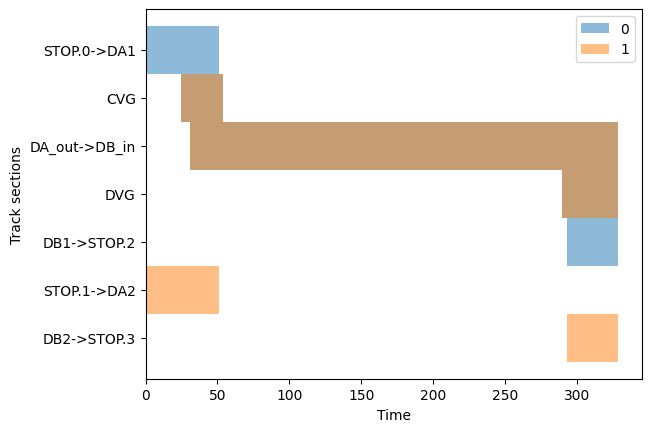

In [14]:
s.plot()

In [15]:
from regul_env import RegulEnv

In [16]:
env = RegulEnv(s, stations = ['DB1->STOP.2', 'DB2->STOP.3'])

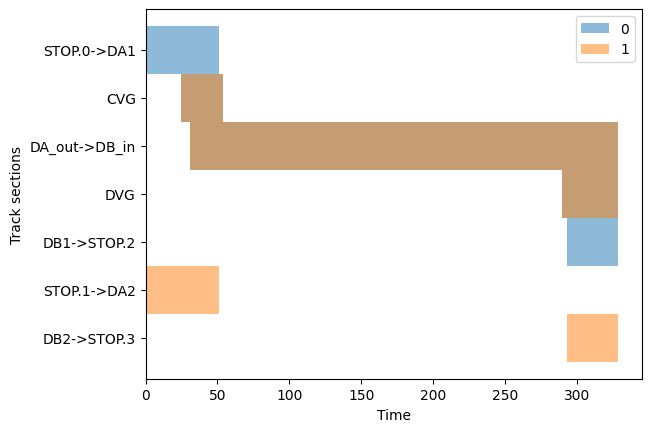

In [17]:
env.reset(train=0, delay=0, track_section='STOP.0->DA1')
env.render()

In [18]:
s.is_a_point_switch(0,1,'CVG')

True

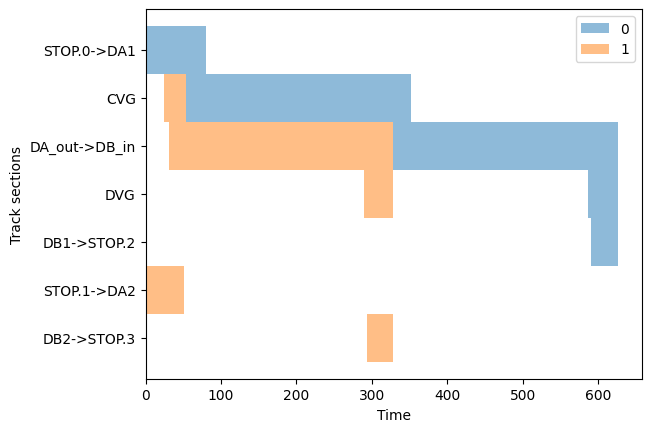

In [19]:
env.step(0)
env.render()
plt.show()

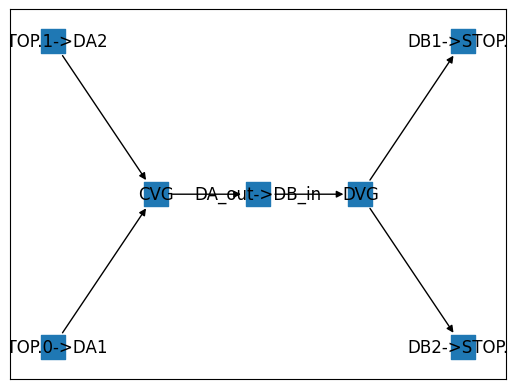

In [20]:
env.schedule.draw_graph()

In [21]:
base_head_positions = res[0]['base_simulations'][0]['head_positions']
eco_head_positions = res[0]['eco_simulations'][0]['head_positions']

t_base = [dict['time'] for dict in base_head_positions]
y_base = [dict['path_offset'] for dict in base_head_positions]
t_eco = [dict['time'] for dict in eco_head_positions]
y_eco = [dict['path_offset'] for dict in eco_head_positions]

Text(0, 0.5, 'Position')

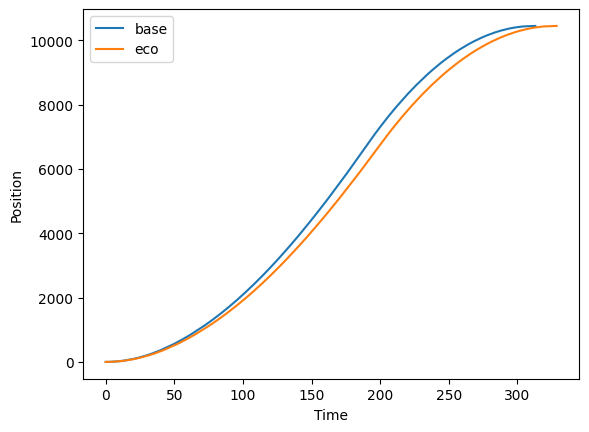

In [25]:
plt.plot(t_base, y_base, label='base')
plt.plot(t_eco, y_eco, label='eco')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')

In [23]:
env